## Чтение очищенных данных

## Библиотеки

In [1]:
# работа с файлами (ETL)
import sys
import os
from pathlib import Path

# работа с данными (DQC & ETL)
import numpy as np
# np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pyxlsb
import scipy

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Чтение данных

In [279]:
%%time

# get directory path
dirpath = os.getcwd()
clean_data_path = Path(dirpath) /'clean_data'


# load data to dict
data = {}
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem)

Test
Training
CPU times: total: 391 ms
Wall time: 400 ms


## Исследование распределений

In [281]:
# calc preparation
numeric_df = data['Training'][data['Training'].select_dtypes(include=[np.number]).columns].copy()
numdata_class1 = numeric_df[numeric_df['MARKER'] == 1]
numdata_class0 = numeric_df[numeric_df['MARKER'] == 0]
num_columns = numeric_df.drop(['MARKER'], axis=1).columns
print(numeric_df.columns)
print(num_columns)

Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'numeric9', 'numeric10', 'MARKER'], dtype='object')
Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'numeric9', 'numeric10'], dtype='object')


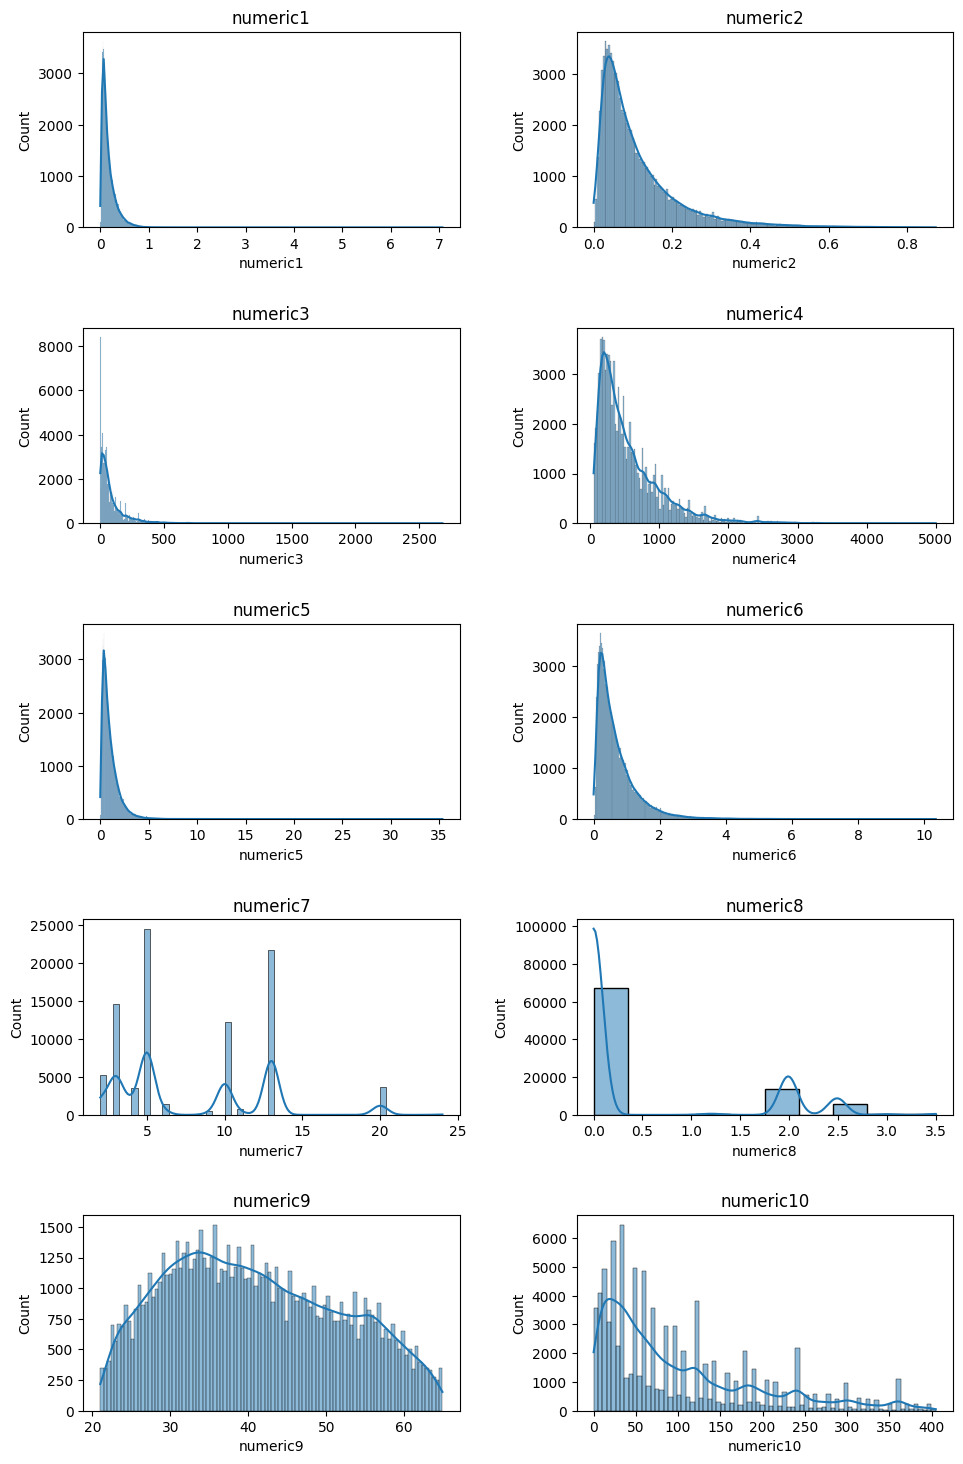

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, column in enumerate(num_columns):
    row, col = divmod(i, 2)
    if column == "numeric8":
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True, bins=10)
    elif column == "numeric9":
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True, bins=100)
    else:
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column)
    axes[row, col].set_xlim(auto=True)
    axes[row, col].set_ylim(auto=True)
    
plt.tight_layout(pad=2, h_pad=2.5)
plt.show()

* Из распредлений видно, что большинство принадлежит экспоненциальному семейству (№ 1, 2, 3, 4, 5, 6, 10 - некоторые в  большей, некоторые в меньше степени). К таким признакам будет применяться логарифмирование с целью попыток приведения их к нормальному распределению, для увелечинения линейной корреляции числовых и  таргетной переменных. Также некоторые модели ( например логистическая регрессия) качественнее обучатся на нормально распределенных данных.
* Признаки 7 и 8 представляют собой дискретные распределения - такие признаки можно либо сразу интерпретировать, как encoded, либо поробовать применить кластеризацию и посмотреть на корреляцию полученных кластеров с таргетом, если корреляция улучшится по сравнению с некластеризованными - значит в ней будет смысл.
* Распределение признака 9 поохоже на что-то между экспоненциальным и нормальным распределением. Его также можно будет попробовать логарифмировать и посмотреть на изменения.

### Экспоненциальные признаки

In [5]:
from scipy.stats import gamma, norm, probplot
columns_to_log = [1, 2, 3, 4, 5, 6, 9, 10]

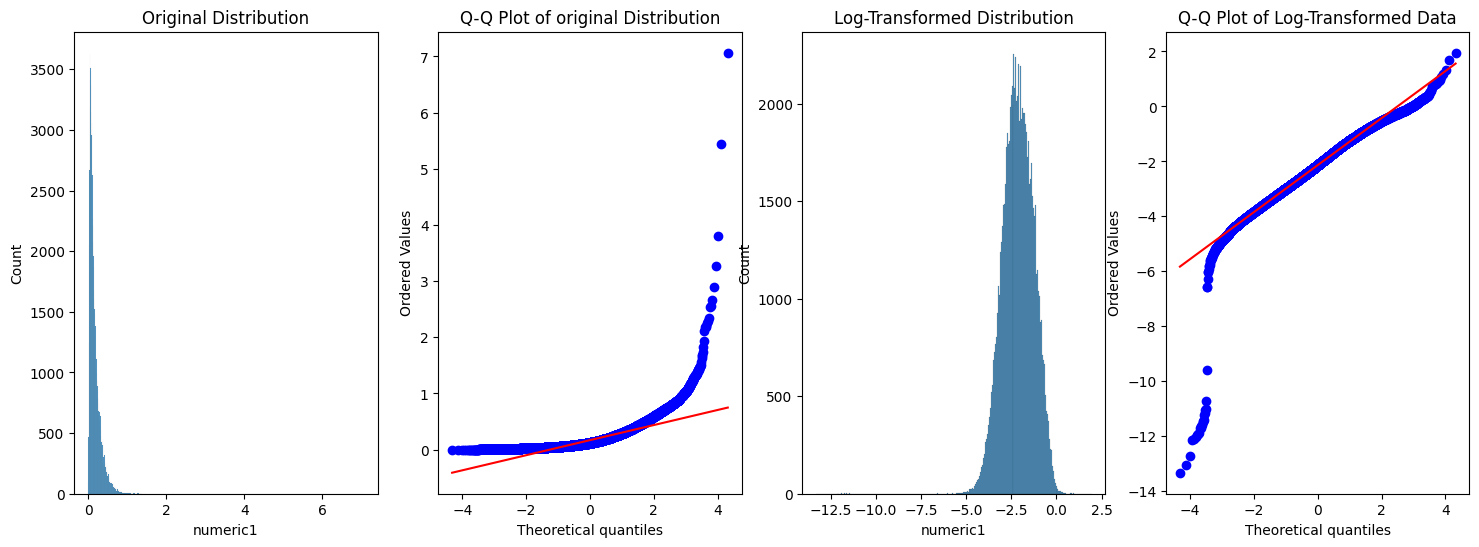

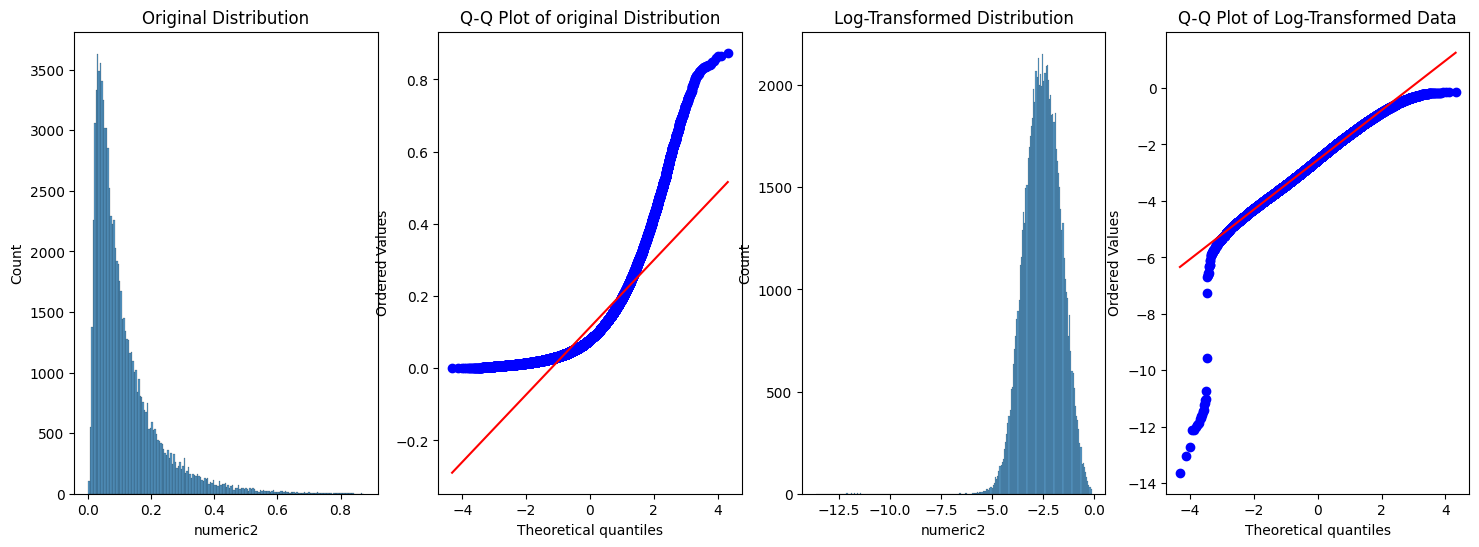

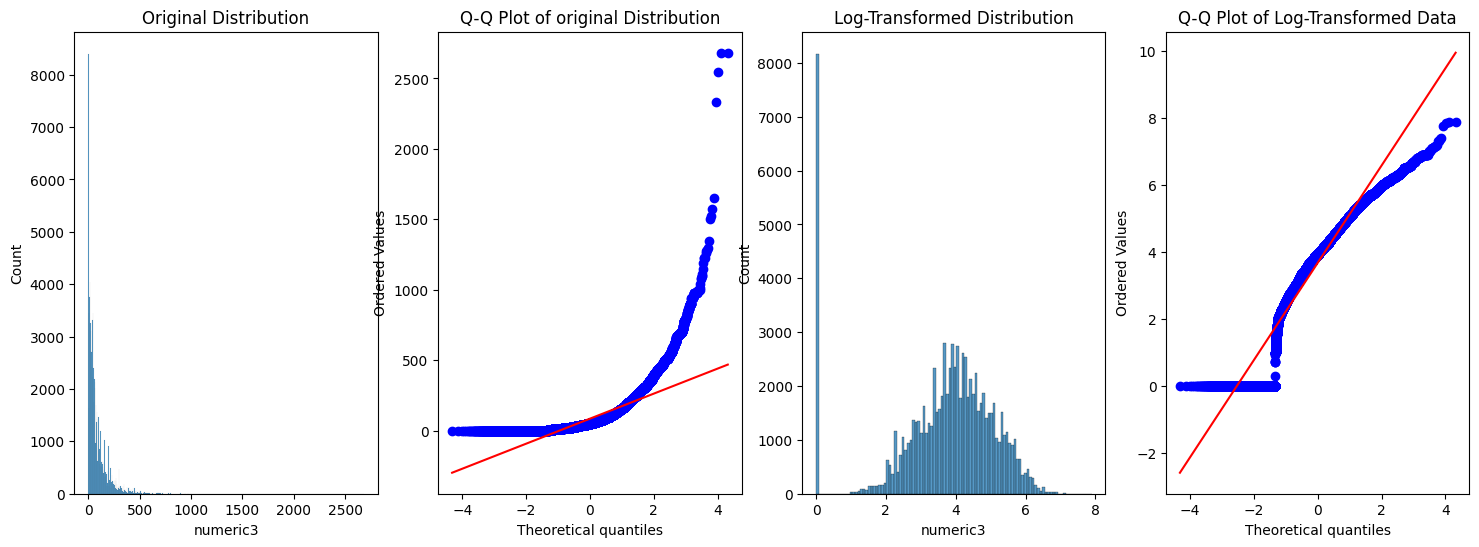

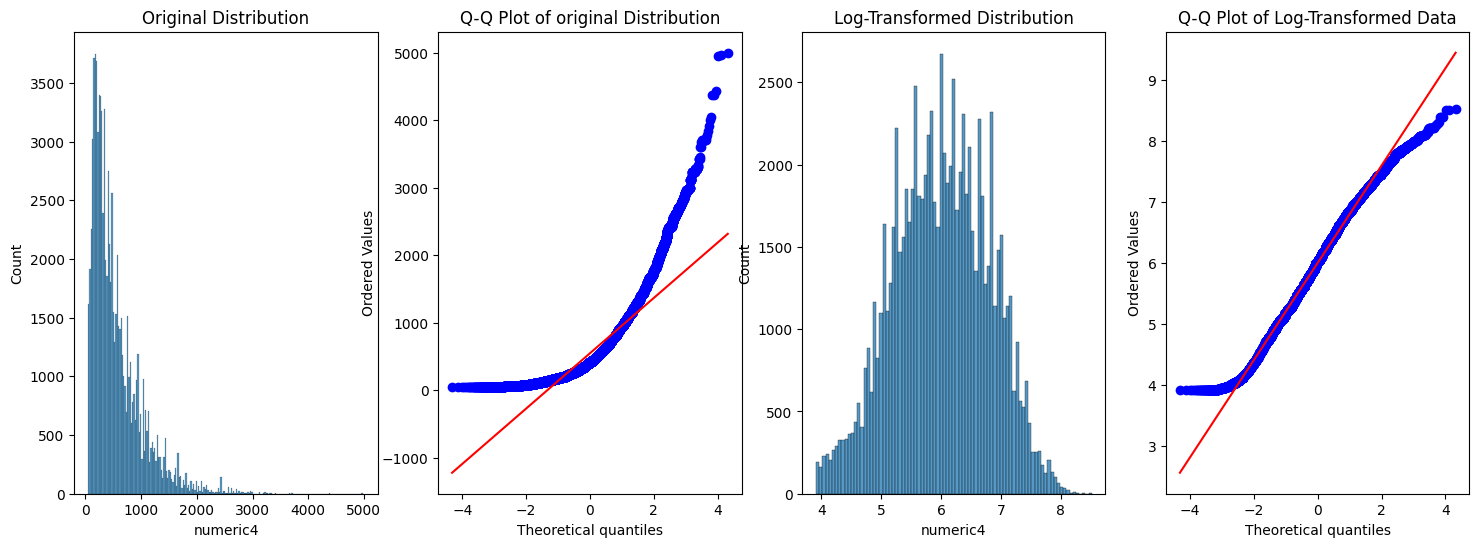

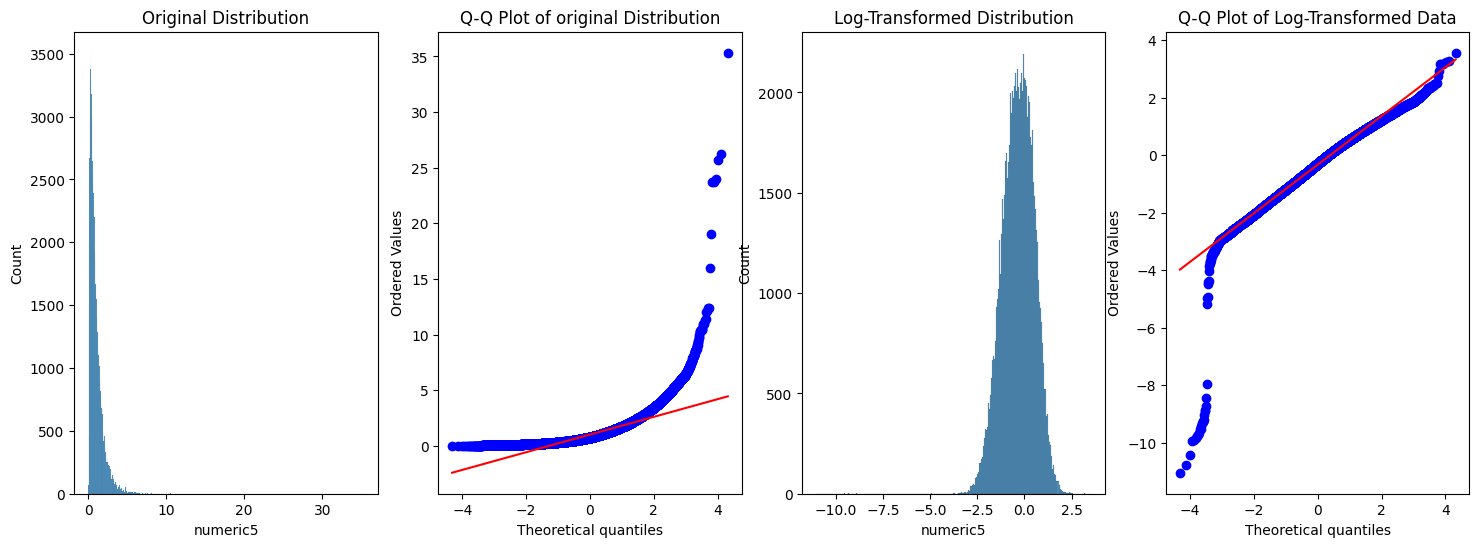

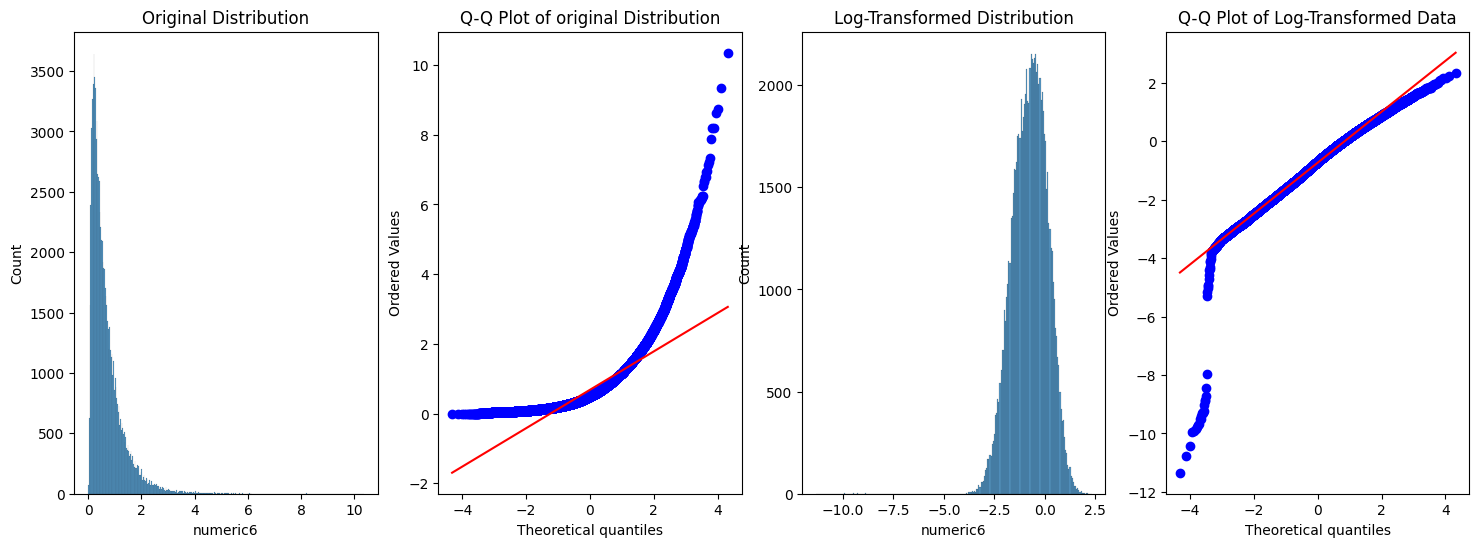

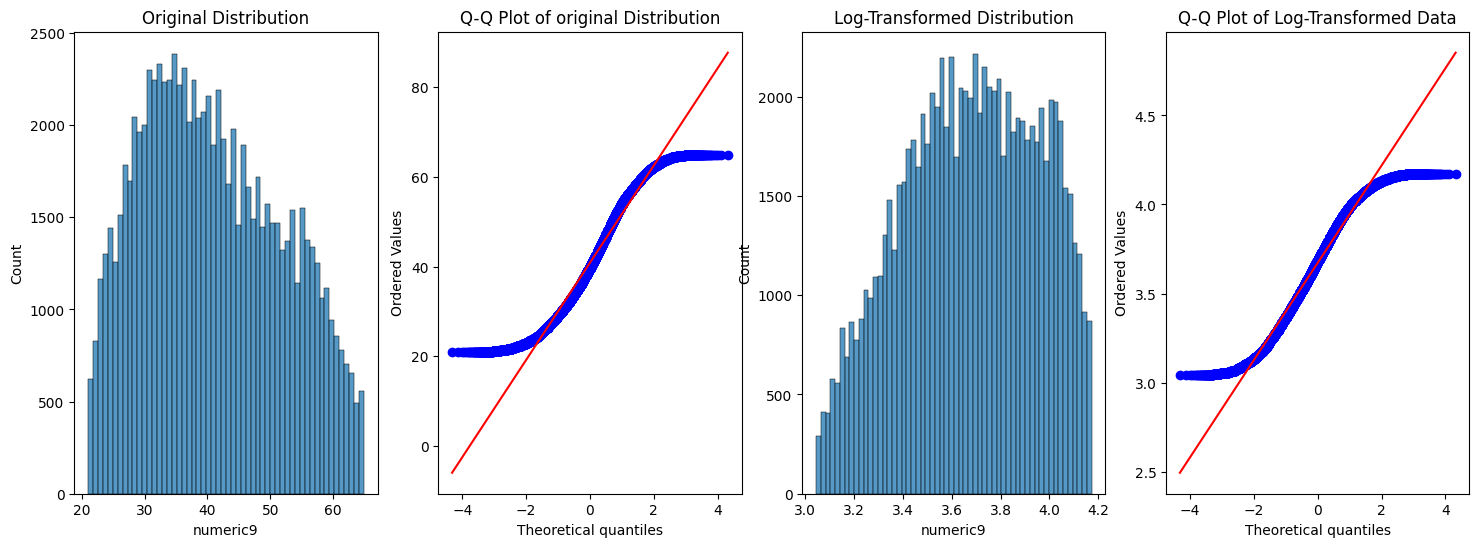

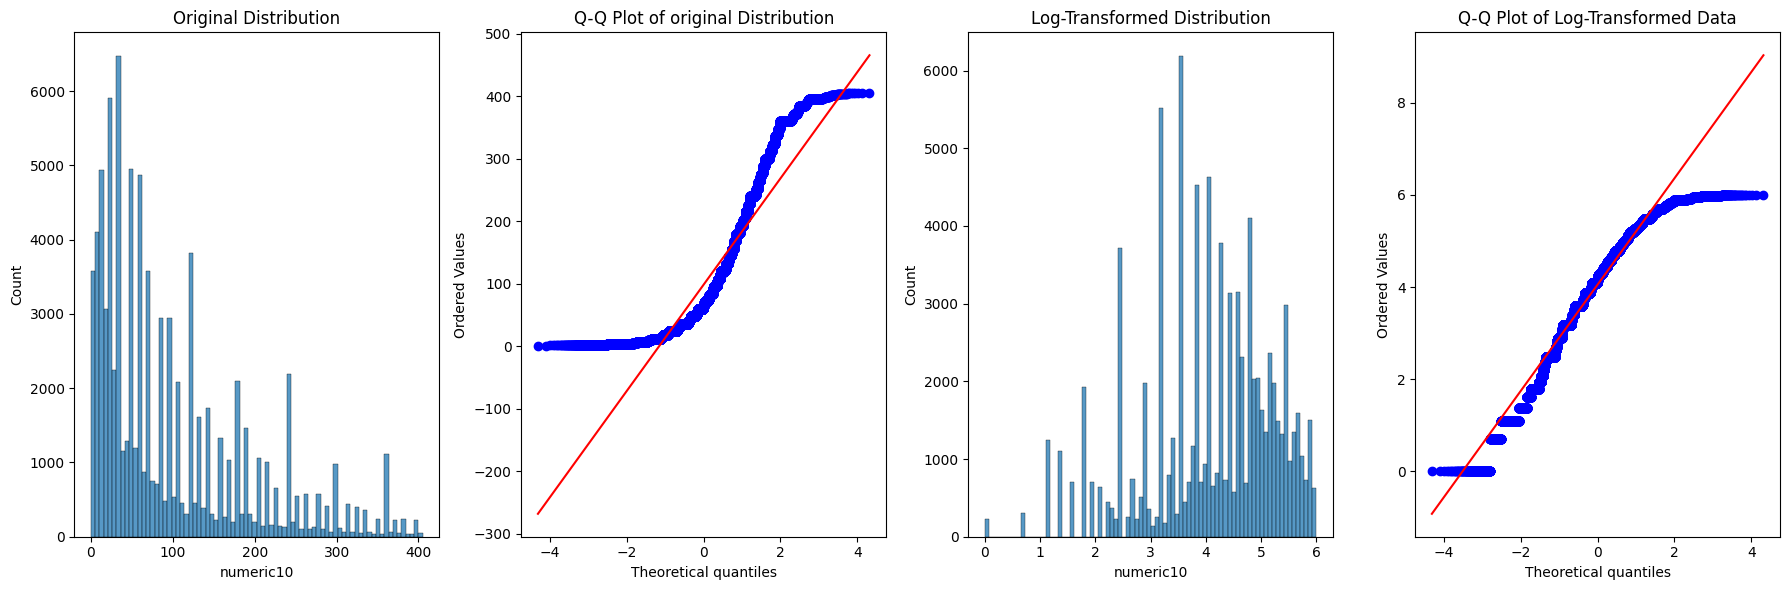

In [6]:
for col_num in columns_to_log:
    col = f'numeric{col_num}'
    plt.figure(figsize=(18, 6))
    
    # Оригинал
    plt.subplot(1, 4, 1)
    sns.histplot(numeric_df[col])
    plt.title('Original Distribution')
    
    # Q-Q plot оригинала
    plt.subplot(1, 4, 2)
    probplot(numeric_df[col], dist="norm", plot=plt)
    plt.title('Q-Q Plot of original Distribution')
    
    # Логарифмическое преобразование
    numeric_df[col] = numeric_df[col].apply(lambda x: np.log(x) if x != 0 else 0)
    
    # Логарифмически преобразованное распределение
    plt.subplot(1, 4, 3)
    sns.histplot(numeric_df[col])
    #p = norm.pdf(x, np.mean(log_col), np.std(log_col))
    #plt.plot(x, p, 'k', linewidth=2)
    plt.title('Log-Transformed Distribution')
    
    # Q-Q plot для проверки нормальности
    plt.subplot(1, 4, 4)
    probplot(numeric_df[col], dist="norm", plot=plt)
    plt.title('Q-Q Plot of Log-Transformed Data')

plt.tight_layout()
plt.show()

По гистограммам и Q-Q графикам после логарифмирования можно наблюдать, что распределения признаков стали близки к нормальным, что и было целью данного преобразования.

### Дискретные признаки

Необходимость кластеризации можно оценить, сгруппировав по уникальным значениям признака и посмотрев, как соотносятся люди которые ушли в дефолт

In [7]:
count1 = numdata_class1.shape[0]
count0 = numdata_class0.shape[0]

# Аггрегация для numeric7
counts_numeric7 = numeric_df.groupby('numeric7')['MARKER'].agg([
    pd.Series.count,
    lambda x: sum(x == 1),
    lambda x: sum(x == 0),
    lambda x: sum(x == 1) / count1 * 100,
    lambda x: sum(x == 0) / count0 * 100
])
counts_numeric7.columns = ['count_numeric7', 'count_class_label_1', 'count_class_label_0', 'perc_class_label_1', 'perc_class_label_0']

# Аггрегация для numeric8
counts_numeric8 = numeric_df.groupby('numeric8')['MARKER'].agg([
    pd.Series.count,
    lambda x: sum(x == 1),
    lambda x: sum(x == 0),
    lambda x: sum(x == 1) / count1 * 100,
    lambda x: sum(x == 0) / count0 * 100
])

counts_numeric8.columns = ['count_numeric8', 'count_class_label_1', 'count_class_label_0', 'perc_class_label_1', 'perc_class_label_0']

In [8]:
counts_numeric7

count_numeric7  count_class_label_1  count_class_label_0  perc_class_label_1  perc_class_label_0
numeric7                                                                                                  
2                   5182                    8                 5174            2.402402            5.879011
3                  14593                   21                14572            6.306306           16.557586
4                   3508                    3                 3505            0.900901            3.982592
5                  24470                   15                24455            4.504505           27.787247
6                   1495                    0                 1495            0.000000            1.698709
9                    500                    2                  498            0.600601            0.565858
10                 12254                   34                12220           10.210210           13.885101
11                   791                    2                  789            0.600601            0.896509
13                 21729                  231                21498           69.369369           24.427325
20                  3670                   13                 3657            3.903904            4.155304
24                   149                    4                  145            1.201201            0.164758

In [9]:
counts_numeric8

count_numeric8  count_class_label_1  count_class_label_0  perc_class_label_1  perc_class_label_0
numeric8                                                                                                  
0.000              62293                   83                62210           24.924925           70.686756
0.010               5038                   17                 5021            5.105105            5.705163
1.100                113                    0                  113            0.000000            0.128397
1.170                108                    1                  107            0.300300            0.121580
1.235                230                    1                  229            0.300300            0.260204
1.320                 49                    0                   49            0.000000            0.055677
1.990              13928                  114                13814           34.234234           15.696300
2.490               5714                   91                 5623           27.327327            6.389192
2.500                277                    8                  269            2.402402            0.305654
2.990                253                   11                  242            3.303303            0.274975
3.000                  1                    0                    1            0.000000            0.001136
3.490                 42                    1                   41            0.300300            0.046587
3.500                295                    6                  289            1.801802            0.328379

Есть значения, в которых один класс в процентном соотношении значительно преобладает над другим, но таких случаев не особо много. Можно будет попробовать кластеризацию, для их объединения.

## Корреляционный анализ

<Axes: >

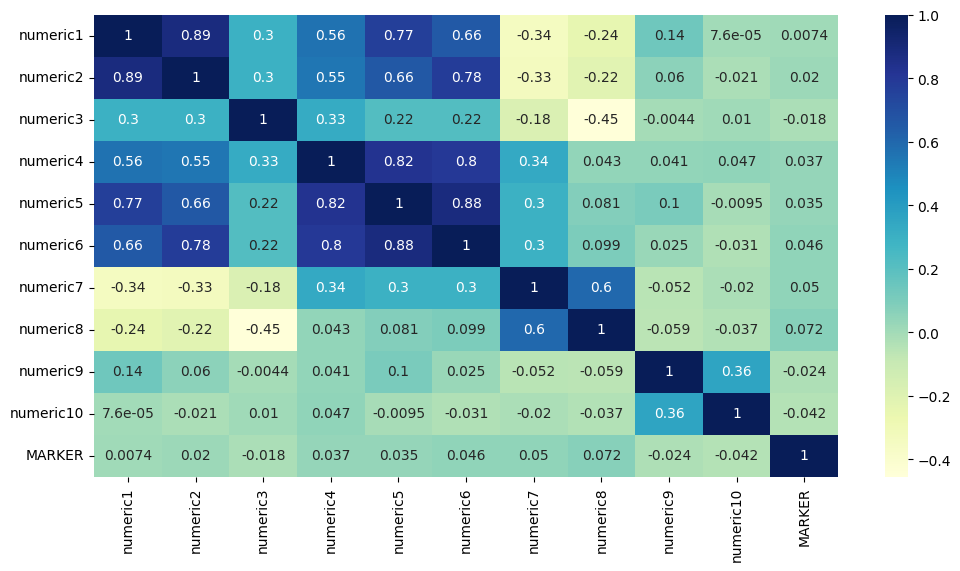

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="YlGnBu")

* Данные очень сильно коррелируют между собой. Если не обработать коррелирующие признаки, при обучении будут проблемы с мультиколлинеарностью.
* Признаки плохо коррелируют с таргеной перменной, что странно. Нужно посмотреть на распределение таргетной переменной.

<Axes: xlabel='MARKER', ylabel='Count'>

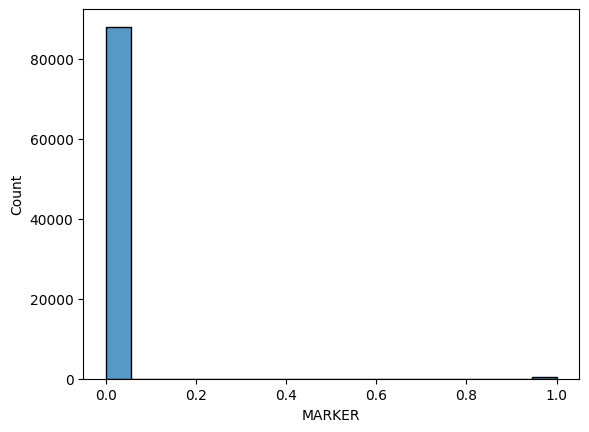

In [11]:
sns.histplot(numeric_df['MARKER'])

In [12]:
print(numeric_df['MARKER'].sum() / numeric_df['MARKER'].count() * 100)

0.3769484157978742


numeric1  numeric2  numeric3  numeric4  numeric7  numeric8   numeric9  numeric10  MARKER
0      0.198778  0.099389      0.00    799.90        13      3.49  33.750000        132       0
1      0.043000  0.021264     49.97    173.03        13      3.49  33.250000          6       0
2      0.067073  0.067073      0.00    329.90        13      3.49  38.583333         71       0
3      0.052700  0.052700      0.00    235.65        13      3.49  61.250000         48       0
4      0.141880  0.141880      0.00    634.45        13      3.49  48.583333         48       0
...         ...       ...       ...       ...       ...       ...        ...        ...     ...
88003  0.027941  0.014844     25.00    474.00        20      0.01  26.833333         14       0
88004  0.120017  0.068581    179.96    720.03        10      0.00  44.583333         48       0
88005  0.153033  0.122427     29.01    550.99         3      0.00  61.250000        288       0
88006  0.107575  0.043030     53.82    215.18         5      0.00  28.833333         30       0
88007  0.095750  0.095750     57.48    172.42         3      0.00  30.500000         36       0

[88008 rows x 9 columns]

* Количество данных с меткой класса 1 всего лишь 0.377% - нужно будет решать проблему несбалансированности классов.
* Наиболее вероятно, корреляция признаков с тагретной переменной видна плохо на тепловой карте из-за несбалансированности классов, нужно попробовать взять случайным образом такое же количество записей из класса 0, сколько имеется всего записей класса 1 и посмотреть на корреляцию снова, чтобы  не попасть на случайную неудачную выборку для класса 0, будет производится многоразовая случайная выборка и считаться средние значения корреляции.

<Axes: >

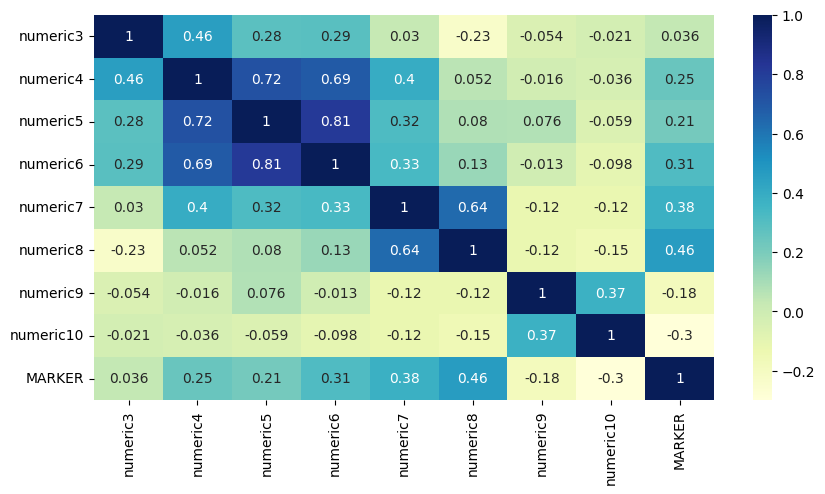

In [264]:
n = 2 * numdata_class1['MARKER'].sum()
corr_arr = []

# .drop(['numeric1', 'numeric2', 'numeric6'], axis=1)

# get samples and calc corr
for _ in range(10000):
    sample = numdata_class0.drop(['numeric1', 'numeric2'], axis=1).sample(n=n)
    concat_sample = pd.concat([sample, numdata_class1.drop(['numeric1', 'numeric2'], axis=1)])
    corr_arr.append(concat_sample.corr().values)

# calc mean
corr_arr = np.array(corr_arr)
mean_corr = np.mean(corr_arr, axis=0)
mean_corr_df = pd.DataFrame(mean_corr, index=concat_sample.columns, columns=concat_sample.columns)

# visualize
plt.figure(figsize=(10, 5))
sns.heatmap(mean_corr_df, annot=True, cmap="YlGnBu")

* Как видим из графика, теперь наблюдаются неплохие корреляции для числовых признаков, с 4ого по 10ый.
* Остальные признаки хоть и плохо коррелируют, но это не означает, что их стоит выбрасывать, возможно они связаны с таргетом нелинейно
* Всё также сохранилась проблема мультиколлинеарности, что говорит о том, что она не ложная (не из-за дисбаланса классов).
* Исходя из того, что были получены неплохие корреляции при малом количестве мажоритарного класса - неплохим решением будет попробовать многократный undersampling.

### Исходя из EDA можно заключить:
* Большинство признаков неплохо коррелируют с таргетной переменной
* Многие численные признаки нужно логарифмировать, а также энкодить строковые переменные для дальнешейго обучения модели.
* Необходимо решить проблему мультиколлинеарности и дизбаланса классов на этапе обработки признаков, либо обучать модели, устойчивые к данным явлениям. На основе этих проблем приоритет пока отдаётся моделям на основе деревьев - бустингу. Также, если хорошо обработать признаки, тем самым решив проблему мультиколлинеарности, можно будет попробовать обучить логистическую регрессию и простую нейросеть.

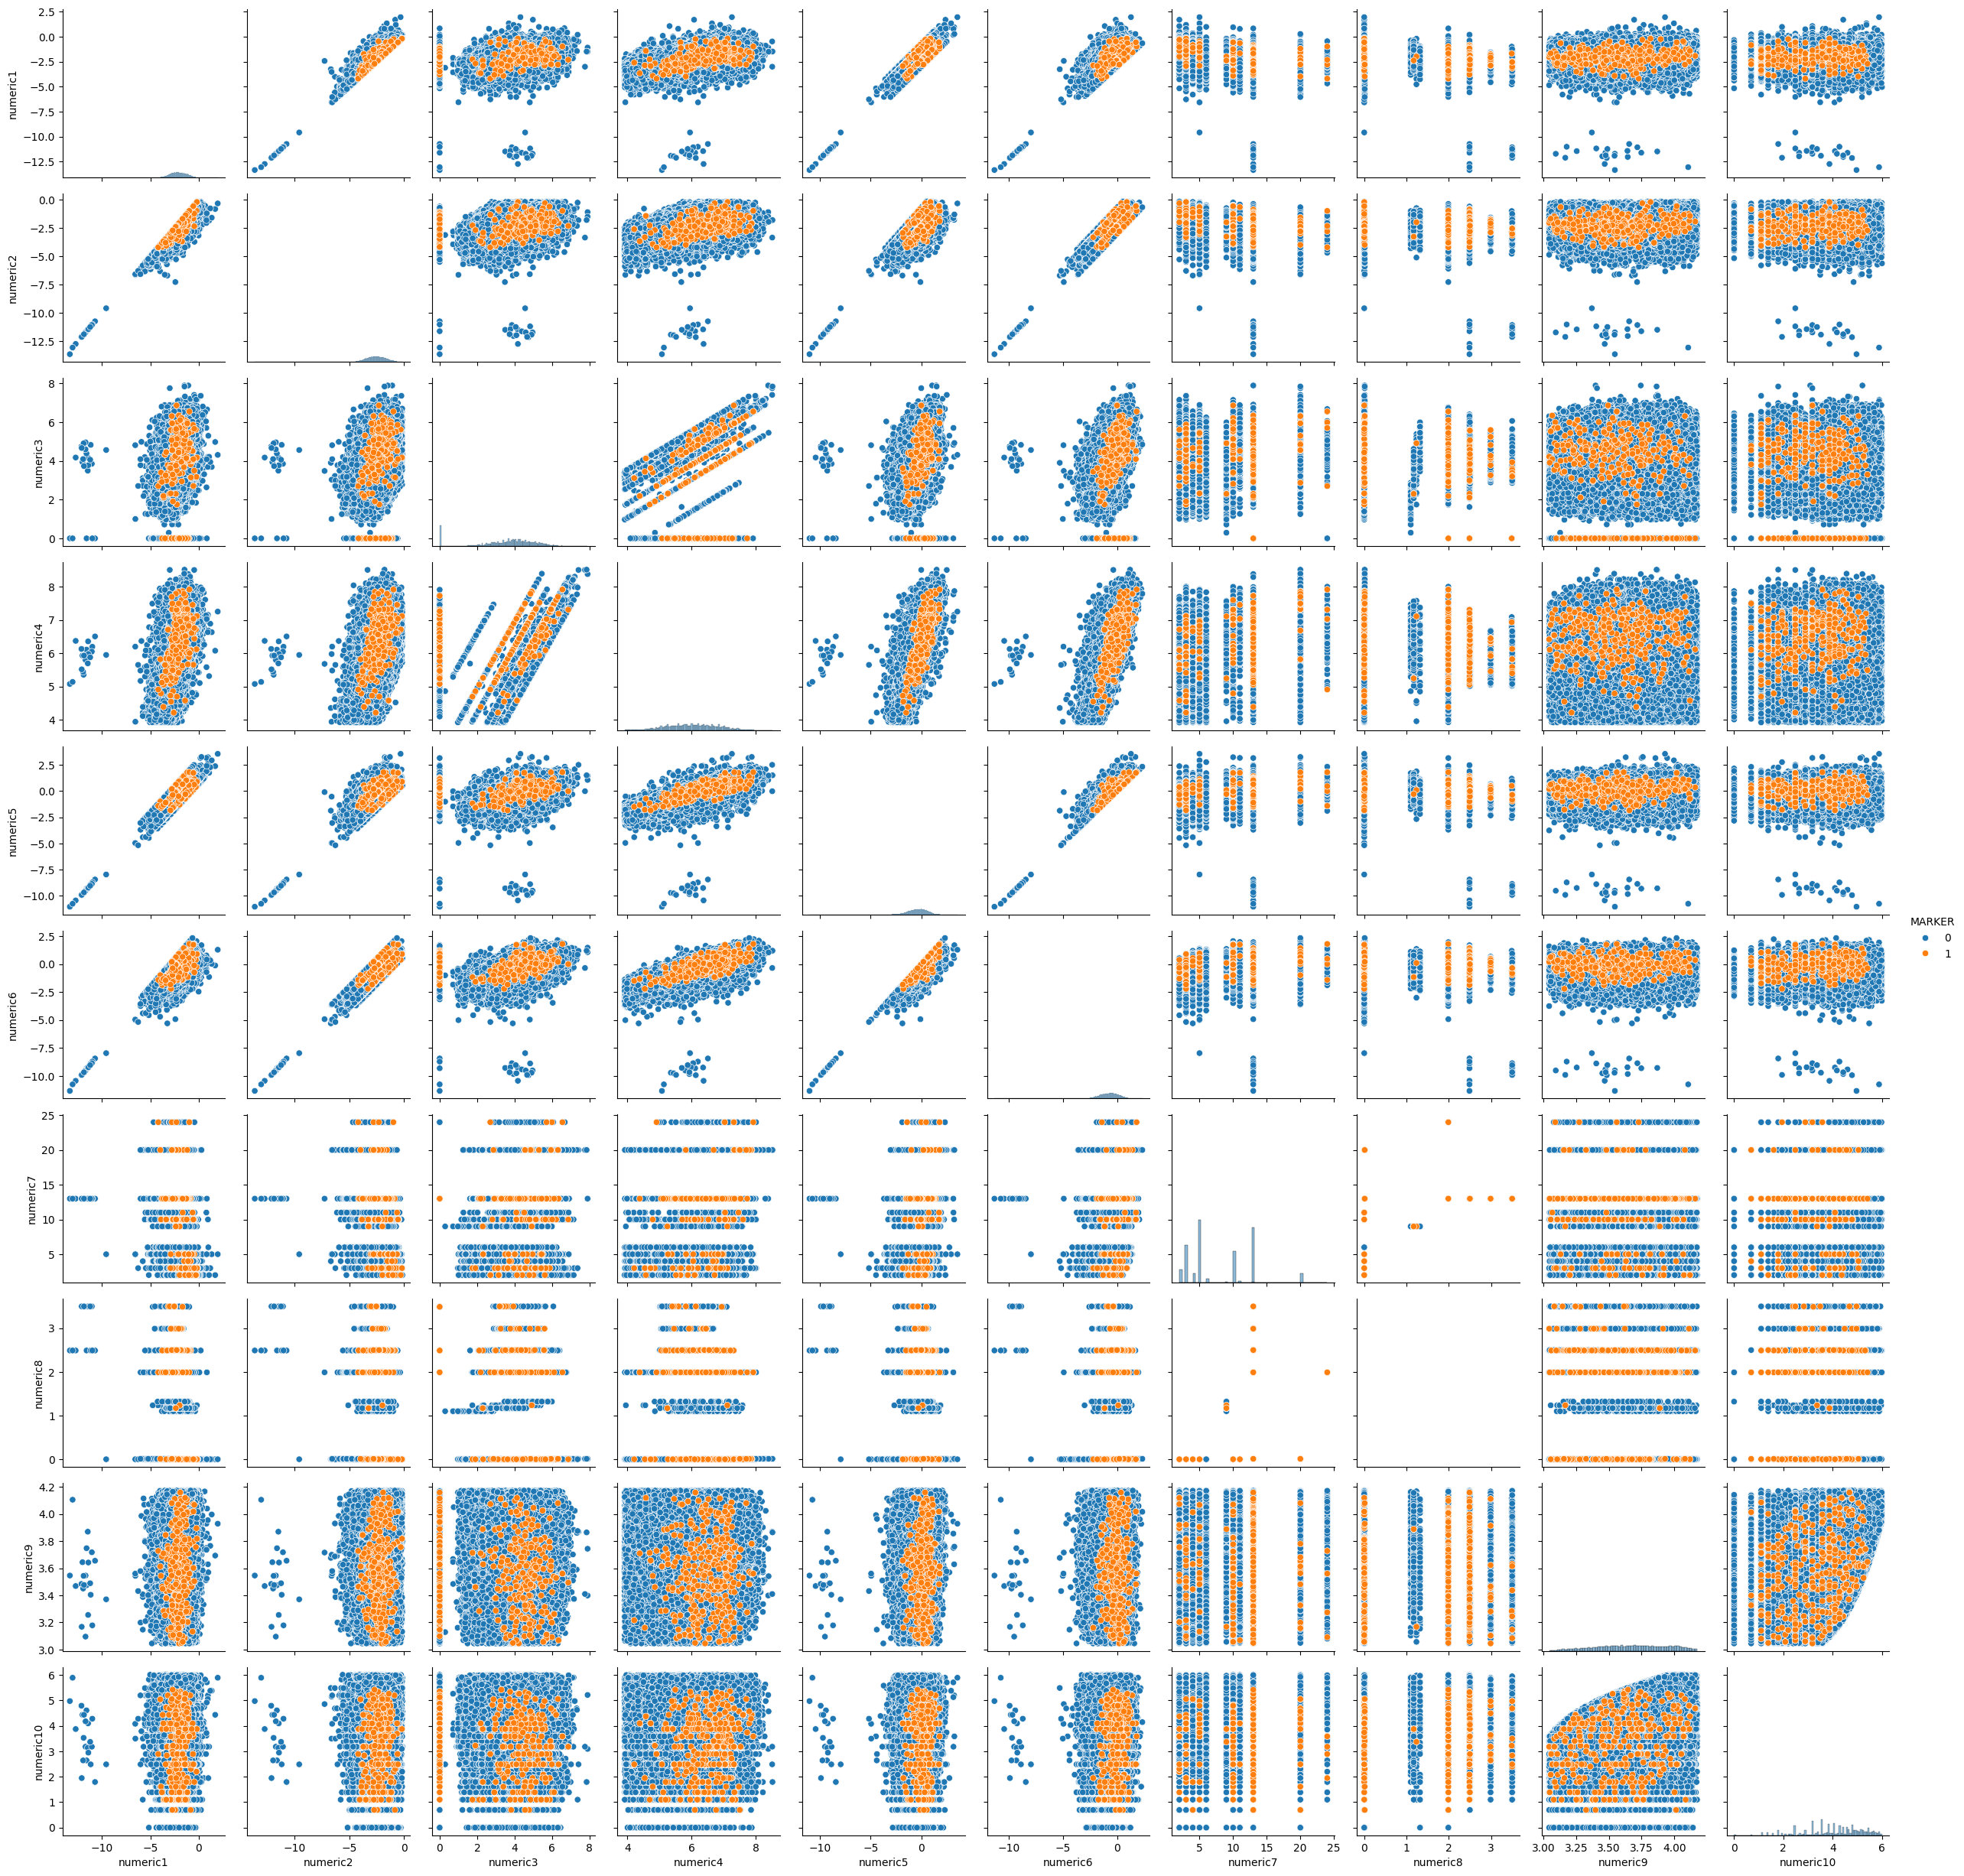

In [55]:
%%time
g = sns.PairGrid(numeric_df, hue='MARKER')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

<Axes: xlabel='numeric1', ylabel='numeric2'>

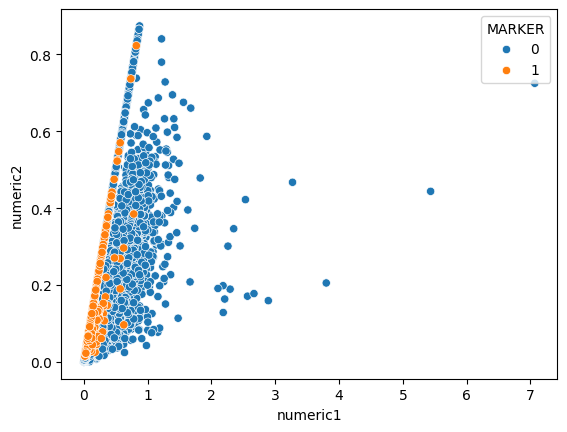

In [301]:
sns.scatterplot(data=numeric_df, x='numeric1', y='numeric2', hue='MARKER')

<Axes: xlabel='numeric1', ylabel='numeric2'>

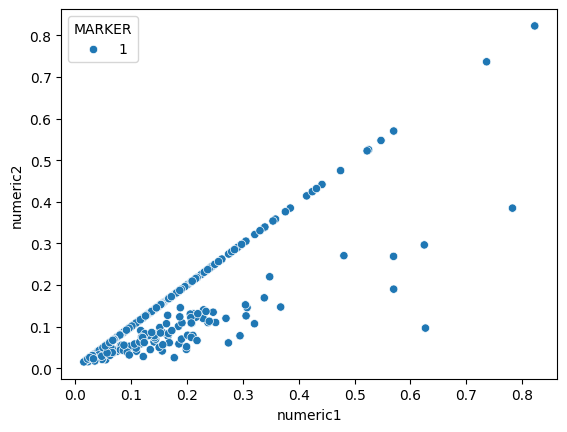

In [297]:
sns.scatterplot(data=numeric_df[numeric_df['MARKER'] == 1], x='numeric1', y='numeric2', hue='MARKER')

<Axes: xlabel='numeric5', ylabel='numeric6'>

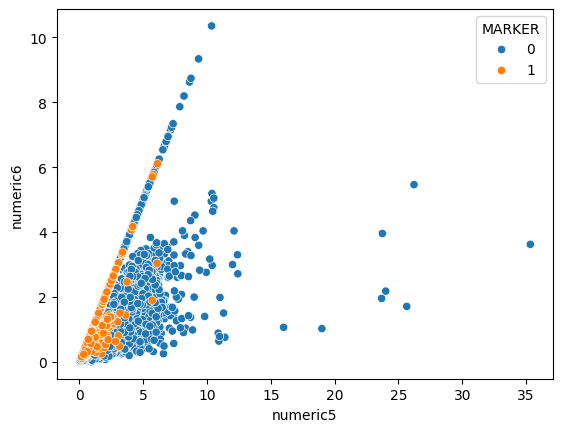

In [300]:
sns.scatterplot(data=numeric_df, x='numeric5', y='numeric6', hue='MARKER')

<Axes: xlabel='numeric5', ylabel='numeric6'>

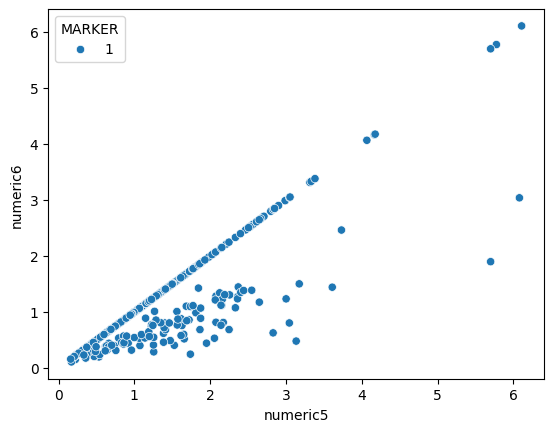

In [299]:
sns.scatterplot(data=numeric_df[numeric_df['MARKER'] == 1], x='numeric5', y='numeric6', hue='MARKER')

<Axes: xlabel='numeric1', ylabel='numeric2'>

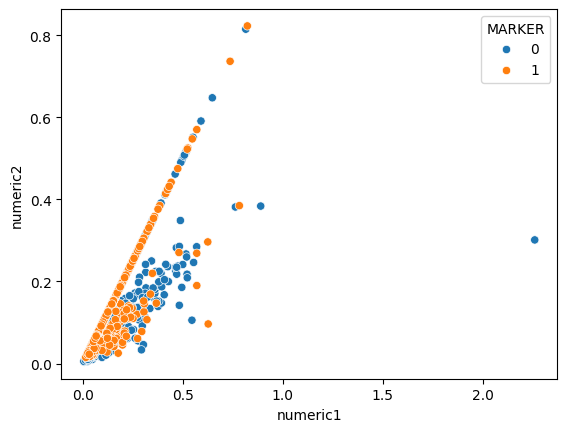

In [293]:
sns.scatterplot(data=numeric_df.tail(1150), x='numeric1', y='numeric2', hue='MARKER')

<Axes: xlabel='numeric5', ylabel='numeric6'>

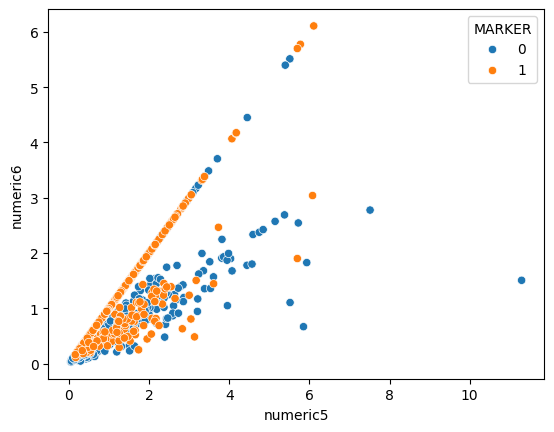

In [294]:
sns.scatterplot(data=numeric_df.tail(1150), x='numeric5', y='numeric6', hue='MARKER')

In [284]:
numeric_df[['numeric1', 'numeric2', 'numeric5', 'numeric6', 'MARKER']].head(50)

numeric1  numeric2  numeric5  numeric6  MARKER
0   0.198778  0.099389  1.777556  0.888778       0
1   0.043000  0.021264  0.384511  0.190143       0
2   0.067073  0.067073  0.599818  0.599818       0
3   0.052700  0.052700  0.471300  0.471300       0
4   0.141880  0.141880  1.268900  1.268900       0
5   0.054657  0.025507  0.488857  0.228133       0
6   0.117114  0.051237  1.047429  0.458250       0
7   0.088231  0.088231  0.789000  0.789000       0
8   0.080296  0.049273  0.829259  0.508864       0
9   0.058360  0.029180  0.521820  0.260910       0
10  0.115800  0.061306  1.035544  0.548229       0
11  0.091657  0.049354  0.819743  0.441400       0
12  0.030917  0.018550  0.276500  0.165900       0
13  0.345057  0.109791  3.085714  0.981818       0
14  0.073500  0.073500  0.657375  0.657375       0
15  0.078929  0.078929  0.705824  0.705824       0
16  0.287071  0.147037  2.567143  1.314878       0
17  0.044715  0.034194  0.399923  0.305824       0
18  0.099378  0.052612  0.888667  0.470471       0
19  0.050700  0.050700  0.453440  0.453440       0
20  0.057767  0.057767  0.516500  0.516500       0
21  0.056000  0.028000  0.500833  0.250417       0
22  0.068442  0.068442  0.612111  0.612111       0
23  0.270564  0.148810  3.512836  1.932060       0
24  0.057677  0.057677  0.515806  0.515806       0
25  0.055444  0.055444  0.495800  0.495800       0
26  0.109507  0.109507  0.979320  0.979320       0
27  0.299450  0.085557  2.678000  0.765143       0
28  0.260122  0.137054  2.326122  1.225591       0
29  0.074911  0.048157  0.669933  0.430671       0
30  0.095037  0.069118  0.849875  0.618091       0
31  0.275800  0.027580  2.466333  0.246633       0
32  0.072486  0.072486  0.648378  0.648378       0
33  0.034660  0.017330  0.309800  0.154900       0
34  0.096063  0.096063  0.859126  0.859126       0
35  0.008527  0.008527  0.076250  0.076250       0
36  0.066375  0.048273  0.593612  0.431718       0
37  0.370312  0.370312  3.311875  3.311875       0
38  0.144357  0.101050  1.290900  0.903630       0
39  0.150154  0.084870  1.342800  0.758974       0
40  0.095545  0.095545  0.854364  0.854364       0
41  0.080480  0.080480  0.719600  0.719600       0
42  0.106293  0.106293  1.380043  1.380043       0
43  0.206800  0.108842  1.849333  0.973333       0
44  0.079750  0.046456  0.783167  0.456214       0
45  0.142540  0.142540  1.399800  1.399800       0
46  0.070675  0.040386  0.694250  0.396714       0
47  0.058800  0.058800  0.577556  0.577556       0
48  0.061329  0.042930  0.602271  0.421590       0
49  0.056157  0.056157  0.551514  0.551514       0

In [249]:
import pandas as pd  
from scipy.stats import pearsonr  

# Предполагая, что у вас есть DataFrame numeric_df  

# Вычисление корреляции между numeric1 и numeric2  
correlation_1 = numeric_df['numeric1'].corr(numeric_df['numeric2'])  
print(f'Корреляция между numeric1 и numeric2: {correlation_1}')  

# Вычисление корреляции между numeric5 и numeric6  
correlation_2 = numeric_df['numeric5'].corr(numeric_df['numeric6'])  
print(f'Корреляция между numeric5 и numeric6: {correlation_2}')  

# Вычисление корреляции между линейными комбинациями  
correlation_combined = numeric_df[['numeric1', 'numeric2']].corrwith(numeric_df[['numeric5', 'numeric6']])  
print(correlation_combined)

Корреляция между numeric1 и numeric2: 0.8859571594079242
Корреляция между numeric5 и numeric6: 0.8835671650957063
numeric1   NaN
numeric2   NaN
numeric5   NaN
numeric6   NaN
dtype: float64


In [250]:
correlation_matrix = numeric_df[['numeric1', 'numeric2', 'numeric5', 'numeric6']].corr()  
print(correlation_matrix)  

          numeric1  numeric2  numeric5  numeric6
numeric1  1.000000  0.885957  0.768886  0.658395
numeric2  0.885957  1.000000  0.660901  0.780717
numeric5  0.768886  0.660901  1.000000  0.883567
numeric6  0.658395  0.780717  0.883567  1.000000


<Axes: xlabel='numeric1', ylabel='MARKER'>

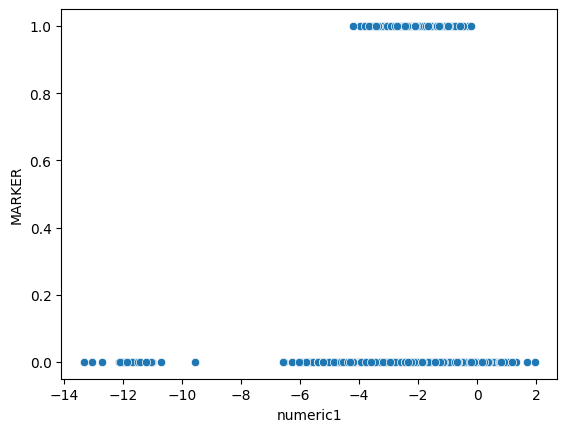

In [242]:
sns.scatterplot(data=numeric_df, x='numeric1', y='MARKER')

<Axes: xlabel='numeric2', ylabel='MARKER'>

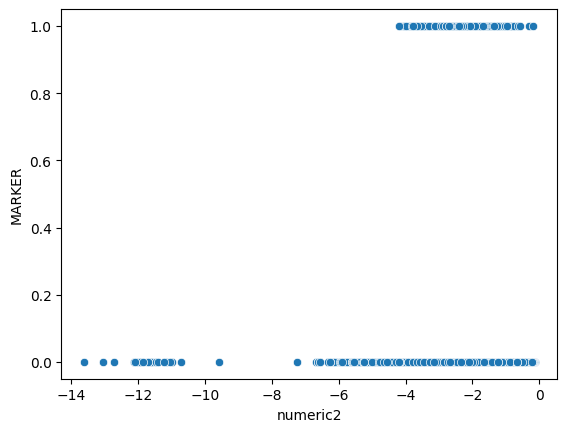

In [243]:
sns.scatterplot(data=numeric_df, x='numeric2', y='MARKER')

In [275]:
pd.DataFrame([numeric_df['numeric1'], numeric_df['numeric2']]).transpose().corr()

numeric1  numeric2
numeric1  1.000000  0.885957
numeric2  0.885957  1.000000